In [1]:
import numpy as np
import time
import generalized_genSim_shorten_time_HMM as ggsdHMM
import numpy as np
import curve_fitting as cf
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import bluepyopt.deapext.algorithms as algo
import vclamp_evaluator_HMMtoHH as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf
import generalized_genSim_shorten_time as ggsd
import eval_helper_na12mut8st as ehn
import HMM_plotter as plotter

In [2]:
p = [1.6145008130686316,
 1.2702355752969856,
 0.2856140201135051,
 2.000672353749617,
 159.19293105141264,
 0.8882089670901088,
 1.54307338742142,
 4.835533385345919,
 184.46766214071704,
 0.6193119174876813,
 8.851518497666747,
 0.07019281223744751,
 46.30970872218895,
 12.027049656918223,
 1.0303204433640094,
 0.05027526734333132,
 1791.9670172949814,
 1.3053734595552096,
 20.37380422148677,
 -9.174778056184731]

import eval_helper as eh
eh.change_params(p, scaled=False, is_HMM=True)

ValueError: not enough values to unpack (expected 5, got 4)

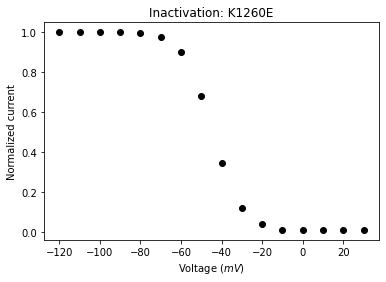

In [3]:
plotter.make_inact_plots(p, "K1260E", "./csv_files/mutant_protocols.csv", p, "./Plots_Folder/jinan_test.pdf", is_HMM = True, channel_name = "na12mut")


(actual, goal)
activation v half: (0.0, -0.2155)
activation slope: (1.0, 1.1159999999999999)


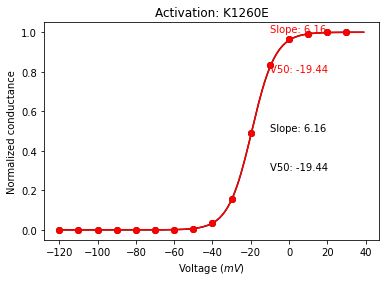

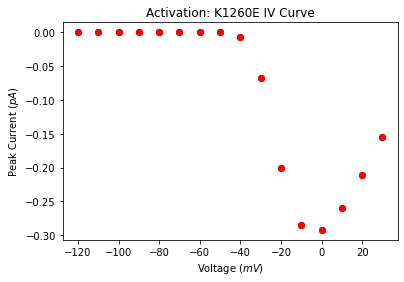

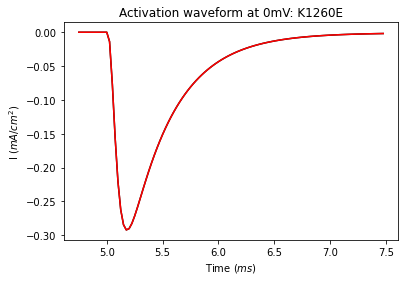

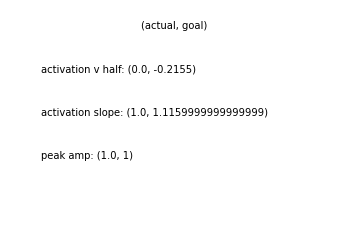

In [4]:
plotter.make_act_plots(p, "K1260E", "./csv_files/mutant_protocols.csv", p, "./Plots_Folder/jinan_test.pdf", is_HMM = True, channel_name = "na12mut")
    

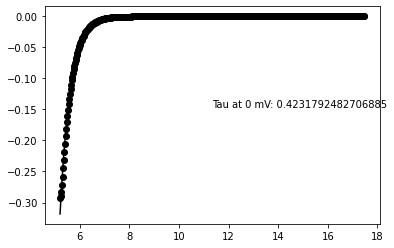

In [7]:
wt_inact = h.Inactivation()
wt_inact.genInactivation()
wt_tau = wt_inact.plotInactivation_Tau_0mV_plt(plt, 'black')
wt_per_cur = find_persistent_current()

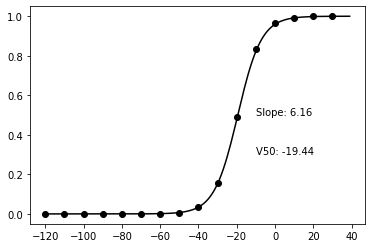

In [4]:
wt_act = ggsdHMM.Activation()
wt_act.genActivation()
# (formatted_v_half, formatted_gv_slope)
act_v_half_wt, act_slope_wt = wt_act.plotActivation_VGnorm_plt(plt, 'black')

